## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from joblib import Parallel, delayed
import os
from multiprocessing import shared_memory
from multiprocessing.pool import ThreadPool
from tqdm import tqdm
import numba
from typing import Tuple, List, Optional
from matchms import Spectrum
from matchms.typing import SpectrumType
import numpy as np
import pandas as pd
from pathlib import Path
import json
from numba import cuda
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import types
import math
import warnings
from numba.core.errors import NumbaPerformanceWarning
import time
from time import perf_counter
from itertools import product
import matplotlib.pyplot as plt
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

# Ignore NumbaPerformanceWarning
warnings.simplefilter("ignore", category=NumbaPerformanceWarning)

def process_spectrum(spectrum):
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

def get_ref_spectra_from_df(spectra_df, limit=None):
    # This function will take a dataframe with spectra and return a list of matchms spectra
    # Argh, This function is annoyingly slow. Added simple parallelization.
    
    # for index, row in spectra_df.iterrows():
    def fn(index, row):
        pbid = row["pbid"]
        precursor_mz = row["precursor_mz"]
        smiles = row["pb_smiles"]
        inchikey = row["pb_inchikey"]
        mz_array = np.array(json.loads(row["peaks_mz"]))
        intensity_array = np.array(json.loads(row["peaks_intensities"]))
        sp = Spectrum(mz=mz_array, intensities=intensity_array,
                        metadata={'id': pbid, 
                                'precursor_mz': precursor_mz, 
                                'smiles': smiles, 
                                'inchikey': inchikey}) 
        sp = process_spectrum(sp)
        return sp
    if limit is not None:
        spectra_df = spectra_df.head(limit)
    spectra = Parallel(-2)(delayed(fn)(index, row) for index, row in tqdm(spectra_df.iterrows(), total=len(spectra_df)) )
    spectra = [s for s in spectra if s is not None]
    return spectra

def spectra_peaks_to_tensor(spectra: list, dtype:str='float32'):
    sp_max_shape = max(len(s.peaks) for s in spectra)
    mz = np.empty((len(spectra), sp_max_shape), dtype=dtype)
    int = np.empty((len(spectra), sp_max_shape), dtype=dtype)
    batch = np.empty(len(spectra),dtype=np.int32)
    for i, s in enumerate(spectra):
        # .to_numpy creates an unneeded copy - we don't need it
        # arr = s.peaks
        mz[i, :len(s.peaks)] = s._peaks.mz#arr[...,0] 
        int[i, :len(s.peaks)] = s._peaks.intensities#arr[...,1]
        batch[i] = len(s.peaks)
    spec = np.stack([mz, int], axis=0)
    return spec, batch

def batches(lst, batch_size):
    """
    Batch data from the iterable into tuples of length n. The last batch may be shorter than n.
    """
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

def argbatch(lst, batch_size):
    """
    Batch data from the iterable into tuples of start-end indices
    """
    for i in range(0, len(lst), batch_size):
        yield i, i + batch_size

assert cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 2070 with Max-Q Design'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


In [4]:
# ref_spectra_df_path = Path("data/input/example_dataset_tornike.csv")
ref_spectra_df_path = Path("data/input/test_set_cosine.csv")
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
# 16384
limit = None
large_references = get_ref_spectra_from_df(ref_spectra_df, limit=limit)
if limit is not None and len(large_references) < limit:
    print(f"Limit is {limit} but and we have {len(large_references)} samples")

100%|██████████| 10000/10000 [00:04<00:00, 2126.76it/s]


In [6]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch
BATCH_SIZE = 1024 * 2

# We know absolute max spectrum size we can have...
MN = max(len(s.peaks) for s in large_references)

## GPU-specific constants
# Threads per block (max is 32,32)
# Blocks per grid (enough to cover all Rs and Qs)
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# 'float32' runs MUCH faster, and has around ~0.05% error rate
# 'float64' is slower, but has ~0.00095% error rate
# Greedy cosine is an unstable algorithm, 
# so it's virtually impossible to have 0% error rate
dtype = 'float64'

# Smaller match limit increases speed dramatically!
# But any value less than M * N will cause a tiny portion of 
# pairs to "overflow" and have tiny error in calculation.
# It is much more efficient to calculate these overflows 
# separately rather than to increase MATCH_LIMIT.
MATCH_LIMIT = 128 * 2

# For keeping track of experiments
CONFIG = dict(
    tolerance = tolerance,
    shift = shift,
    mz_power = mz_power,
    int_power = int_power,
    match_limit = MATCH_LIMIT,
    batch_size = BATCH_SIZE,
)

In [4]:
@cuda.jit
def process(
            rspec: DeviceNDArray,
            qspec: DeviceNDArray,
            
            lens: DeviceNDArray,          
            
            out: DeviceNDArray,
            overflow: DeviceNDArray,
            ):
    i,j = cuda.grid(2)
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    
    # mem = cuda.shared.array((8, ))
    # We aren't out of the RxQ grid
    if i < BATCH_SIZE and j < BATCH_SIZE:
        # Init values (we expect these to be uninitialized)
        overflow[i,j] = 0
        out[i,j] = 0
        
        # mem = cuda.shared.array((4, 4, 4, 32), types.float32)
        rmz = rspec[0]
        rint = rspec[1]
        qmz = qspec[0]
        qint = qspec[1]
        # In this i,j, We get length of r and q spectrums 
        # since they are batched, there might be extra filler elements
        rlen = lens[0]
        qlen = lens[1]
        
        rleni = rlen[i]
        qlenj = qlen[j]
        
        spec1_mz = rmz[i]
        spec1_int = rint[i]
        
        spec2_mz = qmz[j]
        spec2_int = qint[j]
        
        lowest_idx = types.int32(0)
        num_match = types.int32(0)
        
        matches = cuda.local.array((2, MATCH_LIMIT), types.int16)
        for peak1_idx in range(rleni):
            mz = spec1_mz[peak1_idx]

            low_bound = mz - tolerance
            high_bound = mz + tolerance
            
            for peak2_idx in range(lowest_idx, qlenj):
                mz2 = spec2_mz[peak2_idx] + shift
                if mz2 > high_bound:
                    break
                if mz2 < low_bound:
                    lowest_idx = peak2_idx
                else:
                    if num_match < MATCH_LIMIT:
                        matches[0, num_match] = peak1_idx
                        matches[1, num_match] = peak2_idx
                        num_match += 1
                    else:
                        overflow[i, j, 0] = 1 # This is the errorcode for overflow
                        break

        if num_match == 0: 
            return
        
        # SLOW, calculate norm ( This should be done in several threads )
        # score_norm = types.float32(0.0)
        score_norm = types.float32(1.0)
        score_norm_spec1 = types.float32(0.0)
        score_norm_spec2 = types.float32(0.0)
        
        for peak1_idx in range(rleni):
            score_norm_spec1 += ((spec1_mz[peak1_idx] ** mz_power) * (spec1_int[peak1_idx] ** int_power)) ** 2
        for peak2_idx in range(qlenj):
            score_norm_spec2 += ((spec2_mz[peak2_idx] ** mz_power) * (spec2_int[peak2_idx] ** int_power)) ** 2
        score_norm = math.sqrt(score_norm_spec1 * score_norm_spec2)
        
        # Quite slow - Bubble sort (This should also be done in several threads)
        # We need two cases, bubble sort up to 50 elems is fine
        score = types.float32(0.0)
        used_matches = types.int32(0)
        for _ in range(0, num_match):
            max_prod = types.float64(-1.0)
            max_peak1_idx = -1
            max_peak2_idx = -1
            
            for sj in range(0, num_match):
                if matches[0, sj] >= 0:
                    peak1_idx = matches[0, sj]
                    peak2_idx = matches[1, sj]
                    
                    power_prod_spec1 = (spec1_mz[peak1_idx] ** mz_power) * (spec1_int[peak1_idx] ** int_power)
                    power_prod_spec2 = (spec2_mz[peak2_idx] ** mz_power) * (spec2_int[peak2_idx] ** int_power)
                    prod = power_prod_spec1 * power_prod_spec2
                    if prod > max_prod:
                        max_prod = prod
                        max_peak1_idx = peak1_idx
                        max_peak2_idx = peak2_idx

            if max_prod > 0:
                for sj in range(0, num_match):
                    if matches[0, sj] == max_peak1_idx or matches[1, sj] == max_peak2_idx:
                        matches[0, sj] = -1 # "Remove" it
                        matches[1, sj] = -1 # "Remove" it
                score += max_prod
                used_matches += 1
                
            if max_prod < 0:
                break
            
        score = score / score_norm
            
        out[i,j,0] = score
        out[i,j,1] = used_matches

## Regular CPU-bound run:

In [5]:
references = large_references
queries = large_references

print(f"Total pairs to compare: {len(references)} * {len(queries)} = {len(queries) * len(references)}")

Total pairs to compare: 9738 * 9738 = 94828644


In [8]:
from cudams.cosine import similarity

spec1s = []
for i,spectrum_1 in enumerate(references):
    spec1s.append(spectrum_1.peaks.to_numpy)
    
spec2s = []
for j,spectrum_2 in enumerate(queries):
    spec2s.append(spectrum_2.peaks.to_numpy)
    
total=len(spec1s) * len(spec2s)

spec1b = batches(spec1s, BATCH_SIZE)
spec2b = batches(spec2s, BATCH_SIZE)

spec_bs = list(product(spec1b, spec2b))

for batch_i, (spec1s, spec2s) in tqdm(enumerate(spec_bs), total=len(spec_bs)):
    out_true = np.full((BATCH_SIZE, BATCH_SIZE, 2), fill_value=0, dtype='float32')
    for (i, spec1), (j, spec2) in product(enumerate(spec1s), enumerate(spec2s)):
            score = similarity(
                spec1, 
                spec2, 
                tolerance=tolerance,
                shift=shift, 
                mz_power=mz_power,
                int_power=int_power,
            )
            if score is not None:
                out_true[i,j,0] = score[0]
                out_true[i,j,1] = score[1]
    np.save(f'data/tests/d7' / f'{batch_i:05d}.score.npy', out_true)
# duration = time.time() - start_collect_peaks
# print("Time to collect matching pairs:", duration)
# persec = total / duration
# print(f"Speed at {persec:.1f} pairs/sec")
# print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")

# import yaml
# Save results
# experiment = time.strftime("%Y%m%d-%H%M%S")
# experiment = Path('data/tests') / experiment
# experiment.mkdir(exist_ok=True)
# yaml.safe_dump(config, (experiment / 'config.yaml').open('w'))
# np.save(experiment / 'out_true.npy', out_true)

# Compare results
# experiment = sorted(Path('data/tests').glob('*'))[-1]
# out_true_loaded = np.load(experiment / 'out_true.npy')
# assert np.allclose(out_true_loaded, out_true)
# print(f"Accuracy CPU vs CPU: {np.isclose(out_true_loaded, out_true).mean() * 100}%")

  0%|          | 0/25 [00:45<?, ?it/s]


TypeError: unsupported operand type(s) for /: 'str' and 'str'

# GPU-based solution

In [ ]:
rspec, references_cutoff = spectra_peaks_to_tensor(references, dtype=dtype)
qspec, queries_cutoff  = spectra_peaks_to_tensor(queries, dtype=dtype)

rspec_cu = cuda.to_device(rspec)
qspec_cu = cuda.to_device(qspec)

lens_cu = cuda.to_device(np.stack([references_cutoff, queries_cutoff]))

# Batching 
N = rspec_cu.shape[-1] 
M = qspec_cu.shape[-1]

print("Rspec:", rspec_cu.shape, rspec_cu.dtype, "Qspec", qspec_cu.shape, qspec_cu.dtype)

Rspec: (2, 1024, 211) float64 Qspec (2, 1024, 211) float64


In [ ]:
from time import perf_counter
iters = 32

# Init empty (faster) and set values in GPU
out = np.empty((BATCH_SIZE, BATCH_SIZE, 2), dtype='float32')
overflow = np.empty((BATCH_SIZE, BATCH_SIZE, 1), dtype='uint8')

out_cu = cuda.to_device(out)
overflow_cu = cuda.to_device(overflow)

# Warm up
process[(1,1), THREADS_PER_BLOCK](rspec_cu, qspec_cu,
                lens_cu,
                out_cu, overflow_cu,)

perf = perf_counter()
# Iterate kernel `iter` times and average performance
for _ in tqdm(range(iters), desc="Run x32, to get avg perf."):
    process[BLOCKS_PER_GRID, THREADS_PER_BLOCK](
                    rspec_cu, qspec_cu,
                    lens_cu,
                    out_cu, overflow_cu,
                    )
    cuda.synchronize()
duration = perf_counter() - perf
persec = iters * (BATCH_SIZE * BATCH_SIZE) / duration
out_cu.copy_to_host(out)
overflow_cu.copy_to_host(overflow)

print(f"Speed at {persec:.1f}/sec")
print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")

non_overflow = (1-overflow)
out_underflow = out * non_overflow

out_true_underflow = out_true * non_overflow

print("Perfectly correct?:", np.allclose(out, out_true))
print("Except overflows, perfectly correct?:", np.allclose(out_underflow, out_true_underflow))
print(f"Total comparisons: ", BATCH_SIZE * BATCH_SIZE * 2)
tc = np.isclose(out[...,:2], out_true[...,:2])
print(f"Total correct: {(tc).sum()} ({tc.sum() / (BATCH_SIZE * BATCH_SIZE * 2 ) * 100 :.6f}%)")
tc_ov = ((1-tc)*(overflow)).sum()
tc_noov = ((1-tc)*(1-overflow)).sum()
print(f"Total wrong: {(1-tc).sum()} ({(1-tc).sum() / (BATCH_SIZE * BATCH_SIZE * 2 ) * 100 :.6f}%)")
print(f"\t{tc_ov} ({tc_ov / (BATCH_SIZE * BATCH_SIZE * 2 ) * 100 :.6f}%) from overflows; {tc_noov} ({tc_noov / (BATCH_SIZE * BATCH_SIZE * 2 ) * 100 :.6f}%) otherwise")

print("Overflows ====")
print(f"Overflows at MATCH_LIMIT={MATCH_LIMIT} : {overflow.sum()}, {overflow.mean() * 100:.5f}%")

print("Matches =====")
print(f"% correct : {np.isclose(out_underflow[...,1], out_true_underflow[...,1]).mean() * 100:.5f}%")
print(f"% under : {(out_underflow[...,1] < out_true_underflow[...,1]).mean() * 100:.5f}%")
print(f"% over : {(out_underflow[...,1] > out_true_underflow[...,1]).mean() * 100:.5f}%")

print("Scores =====")
print(f"% correct : {np.isclose(out_underflow[...,0], out_true_underflow[...,0]).mean() * 100:.5f}%")

Run x32, to get avg perf.: 100%|██████████| 32/32 [00:01<00:00, 16.27it/s]


Speed at 17047389.5/sec
Estimated 2.44hrs per 100k x 1.5mln
Perfectly correct?: False
Except overflows, perfectly correct?: False
Total comparisons:  2097152
Total correct: 2094206 (99.859524%)
Total wrong: 2946 (0.140476%)
	2932 (0.139809%) from overflows; 14 (0.000668%) otherwise
Overflows ====
Overflows at MATCH_LIMIT=128 : 1488, 0.14191%
Matches =====
% correct : 99.99943%
% under : 0.00038%
% over : 0.00019%
Scores =====
% correct : 99.99924%


# Compare the two results

In [ ]:
cpu = out_true
gpu = out

In [ ]:
print(cpu.shape, gpu.shape)

(1024, 1024, 2) (1024, 1024, 2)


Example: Get normed similarity and num_matches for R no. 42 and Q no. 77.

In [ ]:
print("Sim from CPU: ", cpu[42, 77, 0], " And from GPU", gpu[42, 77, 0])
print("Score of 0 means the we didn't find any matches. So, matches should be 0. Let's check!")

Sim from CPU:  0.0  And from GPU 0.0
Score of 0 means the we didn't find any matches. So, matches should be 0. Let's check!


Get num matches for R no. 42 and Q no. 77.

In [ ]:
print("Sim from CPU: ", cpu[42, 77, 1], " And from GPU", gpu[42, 77, 1])

Sim from CPU:  0.0  And from GPU 0.0


Let's see some other scores that aren't zero. `cpu[32,32]` will show `[<similarity>, <num matches>]` when we print it:

In [ ]:
print('CPU:',cpu[32, 32])
print('GPU:',gpu[32, 32])

CPU: [ 0.457 13.   ]
GPU: [ 0.457 13.   ]


Let's see what happens when GPU overflows! This doesn't ever happen in CPU.
We keep track of overflows in array called `overflow`. If `overflow[i,j] == 1`, an overflow happened while comparing R[i] and Q[i]. However, score should still be reasonably close in CPU/GPU.

In [ ]:
print("Overflow shape", overflow.shape)
print("Small sample of overflow...")
print(overflow[:16,:32].squeeze())
print("If you see any 1's, you are pretty lucky! We have only 0.02% overflows")

Overflow shape (1024, 1024, 1)
Small sample of overflow...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

Let's any first overflow:

In [ ]:
gpu_ov = gpu[(overflow == 1).squeeze()]
cpu_ov = cpu[(overflow == 1).squeeze()]

Let's see them side-by-side:

In [ ]:
np.set_printoptions(precision=5)
print("Overflows only!")
print("GPU score, GPU count, CPU score, CPU count")
print(np.c_[gpu_ov[:16], cpu_ov[:16]])

Overflows only!
GPU score, GPU count, CPU score, CPU count
[[9.02827e-02 5.50000e+01 1.02779e-01 6.00000e+01]
 [5.03936e-01 6.40000e+01 5.03944e-01 6.40000e+01]
 [8.95316e-02 5.90000e+01 8.95345e-02 6.00000e+01]
 [9.81815e-02 5.20000e+01 1.03995e-01 5.90000e+01]
 [5.62814e-01 6.20000e+01 5.62818e-01 6.30000e+01]
 [1.04077e-01 5.40000e+01 1.06113e-01 5.70000e+01]
 [1.66156e-01 6.60000e+01 1.66509e-01 6.70000e+01]
 [3.60311e-01 5.90000e+01 3.66729e-01 7.00000e+01]
 [4.42532e-01 6.00000e+01 4.43200e-01 6.50000e+01]
 [4.86722e-02 6.80000e+01 4.87097e-02 7.10000e+01]
 [4.12475e-02 6.80000e+01 4.12758e-02 7.00000e+01]
 [3.38245e-02 6.50000e+01 3.40067e-02 6.70000e+01]
 [1.60929e-01 6.40000e+01 1.65542e-01 7.40000e+01]
 [3.33284e-01 5.90000e+01 3.78094e-01 7.80000e+01]
 [4.49645e-01 5.80000e+01 4.85082e-01 7.60000e+01]
 [4.52101e-01 5.80000e+01 4.72201e-01 7.30000e+01]]


# Full run (batched GPU solution)

In [7]:
# Prep output dir beforehand
! rm data/output/*.npy
Path('data/output/').mkdir(exist_ok=True)

from cudams.kernel import compile

kernel = compile(tolerance=tolerance, shift=shift, 
                 mz_power=mz_power, int_power=int_power, 
                 match_limit=MATCH_LIMIT, batch_size=BATCH_SIZE)

# Full run
references = large_references
queries = large_references

TOTAL_BATCHES = math.ceil( len(references) / BATCH_SIZE ) * math.ceil( len(queries) / BATCH_SIZE)
print("Total batches: ", TOTAL_BATCHES)
print(f"Total pairs considered: {len(references)} * {len(queries)} = {len(references) * len(queries)}")

# stream_outputs = [np.empty((R, Q, 2), dtype='float32') for _ in range(TOTAL_BATCHES)]
# stream_overflows = [np.empty((R, Q, 1), dtype='uint8') for _ in range(TOTAL_BATCHES)]
streams = [cuda.stream() for _ in range(TOTAL_BATCHES)]

from dataclasses import dataclass


# Preload each batch so that we don't have to load any R,Q twice
# TODO: Guess these can be parallelised more, but it's not worth it to spend time on
# For now...
batches_r = []
for bstart, bend in tqdm(argbatch(references, BATCH_SIZE), desc="Batch all references"):
    rbatch = references[bstart:bend]
    rspec, rlen = spectra_peaks_to_tensor(rbatch, dtype=dtype)
    batches_r.append([rspec, rlen, bstart, bend])

batches_q = list()
for bstart, bend in tqdm(argbatch(queries, BATCH_SIZE), desc="Batch all queries"):
    qbatch = queries[bstart:bend]
    qspec, qlen  = spectra_peaks_to_tensor(qbatch, dtype=dtype)
    batches_q.append([qspec, qlen, bstart, bend])

batches_rq = list(product(batches_r, batches_q))

# Start processing each loaded batch in parallel (using streams)

start = perf_counter()
with ThreadPool(3) as pool:
    for batch_i in tqdm(range(TOTAL_BATCHES)):
        stream = streams[batch_i]
        # out = stream_outputs[batch_i]
        # overflow = stream_overflows[batch_i]
        # out = np.empty((R, Q, 2), dtype='float32')
        out_shm = shared_memory.SharedMemory(create=True, size=(BATCH_SIZE * BATCH_SIZE * 2 * 4))
        out = np.ndarray(shape=(BATCH_SIZE, BATCH_SIZE, 2), dtype='float32', buffer=out_shm.buf)
        
        # overflow = np.empty((R, Q, 1), dtype='uint8')
        overflow_shm = shared_memory.SharedMemory(create=True, size=(BATCH_SIZE * BATCH_SIZE * 1 * 1))
        overflow = np.ndarray(shape=(BATCH_SIZE, BATCH_SIZE, 1), dtype='uint8', buffer=overflow_shm.buf)

        out_cu = cuda.device_array((BATCH_SIZE, BATCH_SIZE, 2), dtype='float32', stream=stream)
        overflow_cu = cuda.device_array((BATCH_SIZE, BATCH_SIZE, 1), dtype='uint8', stream=stream)

        (rspec, rlen, rstart, rend), (qspec, qlen, qstart, qend) = batches_rq[batch_i]
        lens = np.zeros((2, max(BATCH_SIZE, BATCH_SIZE)), 'int32')
        lens[0,:len(rlen)] = rlen
        lens[1,:len(qlen)] = qlen
        with cuda.pinned(rspec, qspec, lens, out, overflow,):
            rspec_cu = cuda.to_device(rspec, stream=stream)
            qspec_cu = cuda.to_device(qspec, stream=stream)
            lens_cu = cuda.to_device(lens, stream=stream)
            kernel(rspec_cu, qspec_cu,
                    lens_cu,
                    out_cu, overflow_cu,
                    stream=stream)
            out_cu.copy_to_host(out, stream=stream)
            overflow_cu.copy_to_host(overflow, stream=stream)

            def end_of_stream_callback(*args):
                def thread_worker(name1, name2):
                    ex_shm = shared_memory.SharedMemory(name=name1)
                    out = np.ndarray(shape=(BATCH_SIZE, BATCH_SIZE, 2), dtype=np.float32, buffer=ex_shm.buf)
                    np.save(f'data/output/{rstart}-{rend}.{qstart}-{qend}.score.npy', out)
                    ex_shm.unlink()
                    
                    ex_shm = shared_memory.SharedMemory(name=name2)
                    overflow = np.ndarray(shape=(BATCH_SIZE, BATCH_SIZE, 1), dtype=np.uint8, buffer=ex_shm.buf)
                    np.save(f'data/output/{rstart}-{rend}.{qstart}-{qend}.ovfl.npy', overflow)
                    ex_shm.unlink()
                    
                pool.apply_async(
                    thread_worker, args=[out_shm.name, overflow_shm.name], 
                    error_callback=lambda e: print("Thread error", e))

            stream.add_callback(
                callback=end_of_stream_callback,
            )

cuda.synchronize()
duration = perf_counter() - start
persec = len(references) * len(queries) / duration
print(f"Speed at {persec:.1f} pairs/sec")
print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 2070 with Max-Q Design'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
Total batches:  25
Total pairs considered: 9738 * 9738 = 94828644


Batch all references: 5it [00:00,  8.81it/s]
Batch all queries: 5it [00:00, 10.80it/s]
100%|██████████| 25/25 [00:30<00:00,  1.22s/it]

Speed at 3103451.4 pairs/sec
Estimated 13.43hrs per 100k x 1.5mln


We make sure that what we've written in the disk is the same as what we have kept in memory.

In [8]:
# # plt.matshow(stream_outputs[0][...,0])
# fs = sorted(Path('data/output/').glob('*.npy'))
# for a,b in zip(stream_outputs, fs):
#     b = np.load(b)
#     assert np.allclose(a,b)

In [9]:
! ls data/output
! du -hs data/output/
! du -hs data/output/*

0-2048.0-2048.score.npy		4096-6144.6144-8192.ovfl.npy
0-2048.2048-4096.ovfl.npy	4096-6144.6144-8192.score.npy
0-2048.2048-4096.score.npy	4096-6144.8192-10240.ovfl.npy
0-2048.4096-6144.ovfl.npy	4096-6144.8192-10240.score.npy
0-2048.4096-6144.score.npy	6144-8192.0-2048.ovfl.npy
0-2048.6144-8192.ovfl.npy	6144-8192.0-2048.score.npy
0-2048.6144-8192.score.npy	6144-8192.2048-4096.ovfl.npy
0-2048.8192-10240.ovfl.npy	6144-8192.2048-4096.score.npy
0-2048.8192-10240.score.npy	6144-8192.4096-6144.ovfl.npy
2048-4096.0-2048.ovfl.npy	6144-8192.4096-6144.score.npy
2048-4096.0-2048.score.npy	6144-8192.6144-8192.ovfl.npy
2048-4096.2048-4096.ovfl.npy	6144-8192.6144-8192.score.npy
2048-4096.2048-4096.score.npy	6144-8192.8192-10240.ovfl.npy
2048-4096.4096-6144.ovfl.npy	6144-8192.8192-10240.score.npy
2048-4096.4096-6144.score.npy	8192-10240.0-2048.ovfl.npy
2048-4096.6144-8192.ovfl.npy	8192-10240.0-2048.score.npy
2048-4096.6144-8192.score.npy	8192-10240.2048-4096.ovfl.npy
2048-4096.8192-10240.ovfl.npy	8192-

# Small sanity-checking

In [ ]:
# This WILL crash if we have too many outputs... limit it with [:16] or something
outputs = sorted(Path('data/output/').glob('*.score.npy'))
outputs = [np.load(o) for o in tqdm(outputs, desc="Load all score files in memory")]

Load all score files in memory: 100%|██████████| 4/4 [00:00<00:00, 339.10it/s]


In [ ]:
# This WILL crash if we have too many outputs... limit it with [:16] or something
experiment = sorted(Path('data/tests').glob('*'))[-1]
outputs_true = sorted(experiment.glob('*.score.npy'))
outputs_true = [np.load(o) for o in tqdm(outputs_true, desc="Load all score files in memory")]

Load all score files in memory: 100%|██████████| 4/4 [00:00<00:00, 372.71it/s]


In [ ]:
for a,b in zip(outputs, outputs_true):
    cl = np.isclose(a,b)
    err = (~(cl[...,0])) * (1-overflow).squeeze() # Not overflow, and not close
    err_v = (a[...,0] - b[...,0])[err == 1]
    print(
        f"Correct w/ MatchLimit: {cl.mean()} \n",
        f"Correct wo/ MatchLimit: {(1-err).mean()} \n",
        f"Error std {err_v.std()}, min {err_v.min()}, max {err_v.max()} \n")

Correct w/ MatchLimit: 0.9999332427978516 
 Correct wo/ MatchLimit: 0.9999322891235352 
 Error std 0.09365172684192657, min -0.573365330696106, max 4.959292709827423e-06 

Correct w/ MatchLimit: 0.9999661445617676 
 Correct wo/ MatchLimit: 0.9999675750732422 
 Error std 0.001421334920451045, min -0.006175994873046875, max 5.899369716644287e-05 

Correct w/ MatchLimit: 0.9999661445617676 
 Correct wo/ MatchLimit: 0.9999675750732422 
 Error std 0.0014208474894985557, min -0.006175994873046875, max 5.899369716644287e-05 

Correct w/ MatchLimit: 0.9996709823608398 
 Correct wo/ MatchLimit: 0.9999904632568359 
 Error std 6.553604907821864e-05, min -0.00016494840383529663, max 9.980052709579468e-06 



In [ ]:
err.mean()

7.62939453125e-06

In [ ]:
overflows = sorted(Path('data/output/').glob('*.ovfl.npy'))
overflows = [np.load(o) for o in tqdm(overflows, desc="Load all overflow files in memory")]

Load all overflow files in memory: 100%|██████████| 15/15 [00:00<00:00, 245.19it/s]


Right now, matching "batches" must have 1.0 (or very close, if overflow happened) in the diagonal, since we selected our references and queries to be exactly the same. 0th batch should be matching, so diagonal must be close to 1.0. Let's see. 

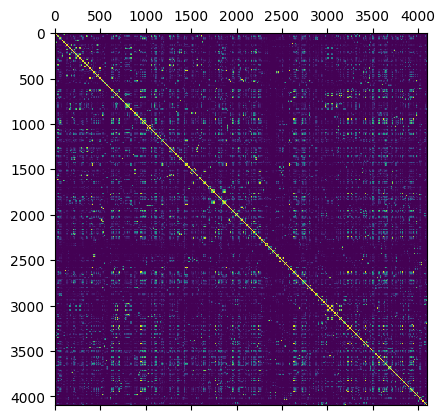

In [ ]:
plt.matshow(outputs[0][...,0])

Let's also see the overflows for first batch - I expect diagonals will have relatively more overall overflows, since spectra matches itself fully.

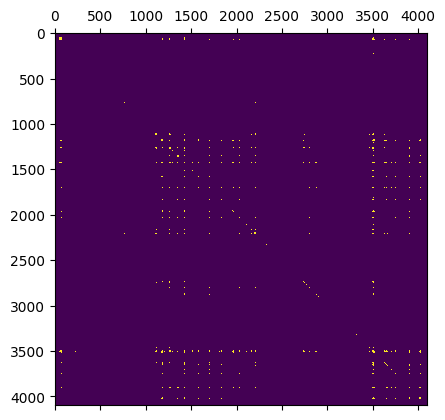

In [ ]:
# It seems we have some "segments" of spectra that have high overflow rate with each-other. This image also has roughly the same outline as the "score" matrix above
plt.matshow(overflows[0][...,0])

Second batch is "mismatched", so no diagonal here.

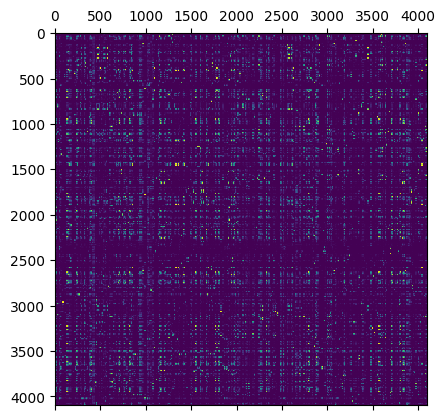

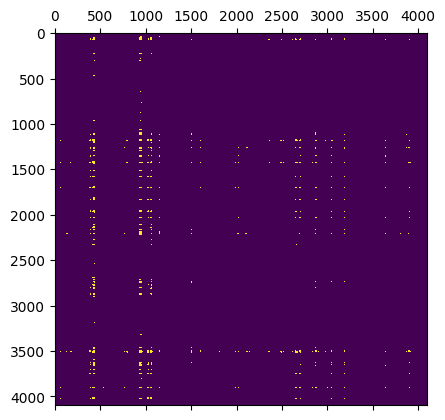

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(outputs[1][...,0])
plt.matshow(overflows[1][...,0])

We can get the next "matched" by the following reasoning:

- We have 16 batches in total. 
- If you aligned these batches in 4x4 grid, in row-major order (fill first row, fill next row, etc)
- Then the second matched batch will be 5.


- **0**, 1, 2, 3,
- 4, **5**, 6, 7,
- ...
- ...

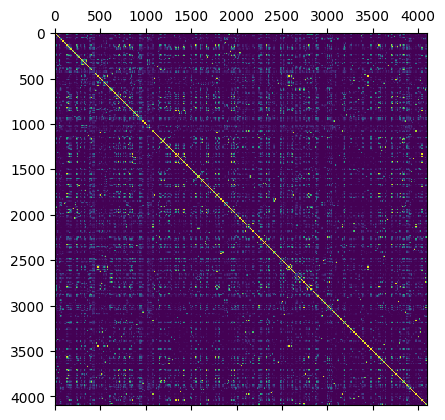

In [ ]:
plt.matshow(outputs[5][...,0])

We know the last batch can be cut-off - because we need to batch refs and ques into R- Q- sized batches, most of the times length of all refs/queries won't 
be perfectly divisible by Q. In this case, we will have a continuous black zero region in the outputs - either many zero columns, or many zero rows, in the right or bottom of the matrix.

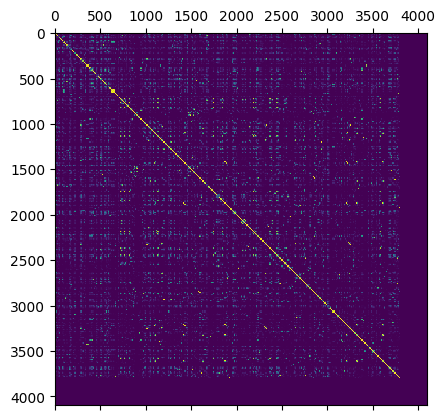

In [ ]:
plt.matshow(outputs[-1][...,0])

Let's see how many overflows we have.

In [ ]:
np.array([ov.sum() for ov in overflows])

array([ 67409, 104051,  42695,  80142, 104052, 151805,  74053, 119611,
        42695,  74053,  33029,  56343,  80142, 119611,  56343,  97855],
      dtype=uint64)

In [ ]:
np.array([ov.mean() for ov in overflows])

array([0.004, 0.006, 0.003, 0.005, 0.006, 0.009, 0.004, 0.007, 0.003,
       0.004, 0.002, 0.003, 0.005, 0.007, 0.003, 0.006])

## TODO

- Design a full 100k x 1.5mln experiment
- Test all values randomly with CPU to find error rates

## Code storage

In [ ]:
# for batch_i, (rbatch, qbatch) in enumerate(product(batches_r, batches_q)):
#     out_true = np.empty((len(rbatch), len(qbatch), 2), dtype='float32')
#     for (i, spec1), (j, spec2) in tqdm( product( enumerate(rbatch), enumerate(qbatch)), total=R * Q):
#         spec1 = spec1.peaks.to_numpy
#         spec2 = spec2.peaks.to_numpy
#         matching_pairs = collect_peak_pairs(
#             spec1,
#             spec2,
#             tolerance=tolerance,
#             shift=shift, 
#             mz_power=mz_power,
#             intensity_power=int_power,
#         )
#         if matching_pairs is not None:
#             matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2])[::-1], :] 
#             score = score_best_matches(matching_pairs, spec1, spec2, 
#                                     mz_power, int_power)
#             scores.append(score)
#             out_true[i,j,0] = score[0]
#             out_true[i,j,1] = score[1]
#         else:
#             out_true[i,j,0] = 0
#             out_true[i,j,1] = 0
#     break

100%|██████████| 1048576/1048576 [00:43<00:00, 24063.04it/s]


In [ ]:
# len(rbatch), len(qbatch)

In [ ]:
# def check_accuracy(out,overflow, out_true):
#     non_overflow = (1-overflow)
#     out_underflow = out * non_overflow

#     out_true_underflow = out_true * non_overflow

#     print("Perfectly correct?:", np.allclose(out, out_true))
#     print("Except overflows, perfectly correct?:", np.allclose(out_underflow, out_true_underflow))
#     print(f"Total comparisons: ", R * Q * 2)
#     tc = np.isclose(out[...,:2], out_true[...,:2])
#     print(f"Total correct: {(tc).sum()} ({tc.sum() / (R * Q * 2 ) * 100 :.6f}%)")
#     tc_ov = ((1-tc)*(overflow)).sum()
#     tc_noov = ((1-tc)*(1-overflow)).sum()
#     print(f"Total wrong: {(1-tc).sum()} ({(1-tc).sum() / (R * Q * 2 ) * 100 :.6f}%)")
#     print(f"\t{tc_ov} ({tc_ov / (R * Q * 2 ) * 100 :.6f}%) from overflows; {tc_noov} ({tc_noov / (R * Q * 2 ) * 100 :.6f}%) otherwise")

#     print("Overflows ====")
#     print(f"Overflows at MATCH_LIMIT={MATCH_LIMIT} : {overflow.sum()}, {overflow.mean() * 100:.5f}%")

#     print("Matches =====")
#     print(f"% correct : {np.isclose(out_underflow[...,1], out_true_underflow[...,1]).mean() * 100:.5f}%")
#     print(f"% under : {(out_underflow[...,1] < out_true_underflow[...,1]).mean() * 100:.5f}%")
#     print(f"% over : {(out_underflow[...,1] > out_true_underflow[...,1]).mean() * 100:.5f}%")

#     print("Scores =====")
#     print(f"% correct : {np.isclose(out_underflow[...,0], out_true_underflow[...,0]).mean() * 100:.5f}%")
    
# check_accuracy(
#     out = stream_outputs[0],
#     overflow = stream_overflows[0],
#     out_true = out_true)

In [ ]:
# # with cuda.defer_cleanup():
# # rspec_cu = cuda.device_array((2, R, MN), dtype=np.float64, stream=stream) # mz+int, R, MN
# # qspec_cu = cuda.device_array((2, Q, MN), dtype=np.float64, stream=stream) # mz+int, Q, MN
# # lens_cu = cuda.device_array((2, R, Q )) # Rlen+Qlen, R
# from itertools import product

# def spectra_peaks_to_tensor(spectra: list, prealloc:list[np.ndarray] = None, dtype:str='float32'):
#     sp_max_shape = max(len(s.peaks) for s in spectra)
#     if prealloc is None:
#         spec = np.empty((2, len(spectra), sp_max_shape), dtype=dtype)
#         batch = np.empty(len(spectra),dtype=np.int32)
#     else:
#         spec, batch = prealloc
#     for i, s in enumerate(spectra):
#         spec[0, i, :len(s.peaks)] = s._peaks.mz
#         spec[1, i, :len(s.peaks)] = s._peaks.intensities
#         batch[i] = len(s.peaks)
#     return spec, batch

# stream_outputs = np.empty((TOTAL_BATCHES, R, Q, 2), dtype='float32')
# streams = [cuda.stream() for _ in range(TOTAL_BATCHES)]
# batches_r = batches(references, R)
# batches_q = batches(queries, Q)
# pairs_batches = product(batches_r, batches_q)

# rspec = np.empty((2, R, MN), dtype=np.float64)
# qspec = np.empty((2, Q, MN), dtype=np.float64)
# lens = np.empty((2, max(R, N)), dtype=np.int32)

# for batch_i, (rbatch, qbatch) in tqdm(enumerate(pairs_batches), total=TOTAL_BATCHES):
#     stream = streams[batch_i]
    
#     rspec, rlen = spectra_peaks_to_tensor(rbatch, prealloc=[rspec, ] dtype=dtype)
#     qspec, qlen  = spectra_peaks_to_tensor(qbatch, dtype=dtype)
#     lens

In [ ]:
# from time import perf_counter, sleep

# N_streams = 10
# with cuda.defer_cleanup():
#     streams = [cuda.stream() for _ in range(1, N_streams + 1)]

#     tics = []  # Launch start times
#     for i, (stream, arr) in enumerate(zip(streams, arrays)):
#         tic = perf_counter()
#         with cuda.pinned(arr):
#             dev_a = cuda.to_device(arr, stream=stream)
#             dev_a_reduce = cuda.device_array(
#                 (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
#             )
#             dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)
            
#             dev_a.copy_to_host(arr, stream=stream)

#         toc = perf_counter()  # Stop time of launches
#         print(f"Launched processing {i} in {1e3 * (toc - tic):.2f} ms")

#         # Ensure that the reference to the GPU arrays are deleted, this will
#         # ensure garbage collection at the exit of the context.
#         del dev_a, dev_a_reduce, dev_a_sum

#         tics.append(tic)

#     tocs = []
#     for i, (stream, arr) in enumerate(zip(streams, arrays)):
#         stream.synchronize()
#         toc = perf_counter()  # Stop time of sync
#         tocs.append(toc)
#         print(f"New sum (array {i}): {arr.sum():12.2f}")
#     for i in range(4):
#         print(f"Performed processing {i} in {1e3 * (tocs[i] - tics[i]):.2f} ms")

#     print(f"Total time {1e3 * (tocs[-1] - tics[0]):.2f} ms")